# Two-Stage Stochastic Energy Scheduling — Benders Decomposition (Walkthrough)

This notebook reproduces the two-stage stochastic program from our assignment:
- **Master**: decide day-ahead schedule \(x_t\) and auxiliary cut variable \(\alpha\).
- **Subproblems (per scenario)**: real-time balancing with battery, wind, market purchase, curtailment, unmet load.
- **Benders cuts**: aggregate duals from the power-balance constraints across scenarios.


In [3]:

# --- Imports
import math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo

# --- Path to your CSV folder (EDIT if needed)
DATA_DIR = Path(r"C:\MOD500\Optimization\Optimization.Assignment")
DATA_DIR


WindowsPath('C:/MOD500/Optimization/Optimization.Assignment')

## Robust CSV loaders

In [4]:

def load_ct(path: Path):
    """Table 1: day-ahead cost c_t (NOK/MWh). Columns can vary slightly; we normalize names."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Cost c_{t} (NOK/MWh)":"c","Cost c_t (NOK/MWh)":"c","Cost":"c"
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    if "c" not in df.columns:    df = df.rename(columns={df.columns[1]:"c"})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["c"]    = pd.to_numeric(df["c"],    errors="coerce")
    df = df.dropna(subset=["hour"]).set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return df

def load_3scen(path: Path):
    """Tables 2–4 with three scenario columns (s1, s2, s3)."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Low demand s = 1":"s1","Medium demand s = 2":"s2","High demand s = 3":"s3",
        "Low demand s=1":"s1","Medium demand s=2":"s2","High demand s=3":"s3",
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    for k in (1,2,3):
        col = f"s{k}"
        if col not in df.columns:
            cands = [c for c in df.columns if c!="hour" and str(k) in c]
            if cands: df = df.rename(columns={cands[0]: col})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    for k in (1,2,3):
        df[f"s{k}"] = pd.to_numeric(df.get(f"s{k}"), errors="coerce")
    df = df.dropna(subset=["hour"])
    df["hour"] = df["hour"].astype(int)
    df = df.set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return df

def load_MCap(path: Path):
    """Table 5: market capacity per hour."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={
        "Hour(t)":"hour","Hour (t)":"hour","Hour":"hour","hour":"hour",
        "Mcap,t (MWh)":"MCap","Mcap (MWh)":"MCap","Mcap":"MCap"
    })
    if "hour" not in df.columns: df = df.rename(columns={df.columns[0]:"hour"})
    if "MCap" not in df.columns: df = df.rename(columns={df.columns[1]:"MCap"})
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["MCap"] = pd.to_numeric(df["MCap"], errors="coerce")
    df = df.dropna(subset=["hour"]).set_index("hour")
    df = df[~df.index.duplicated(keep="first")]
    return df


## Read input data

In [5]:

# Sets and scenario probabilities
T = list(range(1,25))
S = [1,2,3]
p = {1:0.3, 2:0.4, 3:0.3}

# Read all tables
c_df      = load_ct   (DATA_DIR / "table1_ct.csv")
D_df      = load_3scen(DATA_DIR / "table2_D.csv")
W_df      = load_3scen(DATA_DIR / "table3_W.csv")
p_df      = load_3scen(DATA_DIR / "table4_p.csv")   # the cleaned price table
MCap_df   = load_MCap (DATA_DIR / "table5_MCap.csv")

# Convert to dicts
c      = {t: float(c_df.at[t,"c"]) for t in T}
D      = {(s,t): float(D_df.at[t,f"s{s}"]) for s in S for t in T}
W      = {(s,t): float(W_df.at[t,f"s{s}"]) for s in S for t in T}
pprice = {(s,t): float(p_df.at[t,f"s{s}"]) for s in S for t in T}
MCap   = {t: float(MCap_df.at[t,"MCap"]) for t in T}

# Xmax := max_s D[s,t]
Xmax = {t: max(D[(s,t)] for s in S) for t in T}

# Constants
kpen = {(s,t): 320.0 for s in S for t in T}
Emax, Pchg, Pdis = 120.0, 45.0, 55.0
eta_chg, eta_dis = 0.95, 0.95
S0, Smin, Smax   = 60.0, 55.0, 85.0
beta, Punmet     = 12.0, 100000.0

print("Sample:", "c[1]=",c[1], "D[1,1]=",D[(1,1)], "W[1,1]=",W[(1,1)], "p[1,1]=",pprice[(1,1)], "MCap[1]=",MCap[1])


Sample: c[1]= 760.0 D[1,1]= 266.0 W[1,1]= 93.1 p[1,1]= 837.0 MCap[1]= 140.0


## Model builders (master and subproblem)

In [11]:

def build_master(Cuts, integer_x=True):
    m = pyo.ConcreteModel()
    def x_bounds(_m,t): return (0, Xmax[t])
    m.x     = pyo.Var(T, within=pyo.NonNegativeReals, bounds=x_bounds)

    m.alpha = pyo.Var(bounds=(0.0, 1e12))

    m.Cut     = pyo.Set(initialize=Cuts["Set"])
    m.Phi     = pyo.Param(m.Cut, initialize=Cuts["Phi"], mutable=True, default=0.0)
    m.Lambda  = pyo.Param(T, m.Cut,
                          initialize=lambda m,t,c: Cuts["Lambda"].get((t,c),0.0),
                          mutable=True, default=0.0)
    m.x_fixed = pyo.Param(T, m.Cut,
                          initialize=lambda m,t,c: Cuts["x_fixed"].get((t,c),0.0),
                          mutable=True, default=0.0)

    m.obj = pyo.Objective(expr=sum(c[t]*m.x[t] for t in T) + m.alpha, sense=pyo.minimize)

    def cut_rule(m, cidx):
        return m.alpha >= m.Phi[cidx] + sum(m.Lambda[t,cidx]*(m.x[t]-m.x_fixed[t,cidx]) for t in T)
    m.Benders = pyo.Constraint(m.Cut, rule=cut_rule)
    return m

def build_subproblem(x_fixed, s):
    sp = pyo.ConcreteModel()
    sp.T = pyo.Set(initialize=T)

    sp.mkt = pyo.Var(sp.T, within=pyo.NonNegativeReals)
    sp.q   = pyo.Var(sp.T, within=pyo.NonNegativeReals)
    sp.r   = pyo.Var(sp.T, within=pyo.NonNegativeReals)
    sp.u   = pyo.Var(sp.T, within=pyo.NonNegativeReals)
    sp.l   = pyo.Var(sp.T, within=pyo.NonNegativeReals)
    sp.S   = pyo.Var(sp.T)

    sp.obj = pyo.Objective(
        expr=p[s]*sum(pprice[(s,t)]*sp.mkt[t] + kpen[(s,t)]*sp.u[t] + Punmet*sp.l[t] + beta*(sp.q[t]+sp.r[t]) for t in sp.T),
        sense=pyo.minimize
    )

    sp.mcap = pyo.Constraint(sp.T, rule=lambda m,t: m.mkt[t] <= MCap[t])
    sp.qcap = pyo.Constraint(sp.T, rule=lambda m,t: m.q[t]   <= Pchg)
    sp.rcap = pyo.Constraint(sp.T, rule=lambda m,t: m.r[t]   <= Pdis)

    sp.Slo = pyo.Constraint(sp.T, rule=lambda m,t: Smin <= m.S[t])
    sp.Shi = pyo.Constraint(sp.T, rule=lambda m,t: m.S[t] <= Emax)
    def soc(m,t):
        if t==1: return m.S[t] == S0 + eta_chg*m.q[t] - eta_dis*m.r[t]
        return m.S[t] == m.S[t-1] + eta_chg*m.q[t] - eta_dis*m.r[t]
    sp.soc = pyo.Constraint(sp.T, rule=soc)
    sp.Send_lo = pyo.Constraint(expr=sp.S[max(T)] >= Smin)
    sp.Send_hi = pyo.Constraint(expr=sp.S[max(T)] <= Smax)

    sp.balance = pyo.Constraint(
        sp.T,
        rule=lambda m,t: m.r[t] + m.mkt[t] + (W[(s,t)] - m.u[t]) + m.l[t] - m.q[t] == D[(s,t)] - x_fixed[t]
    )

    sp.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    return sp


## Benders loop

Iter 00 | cuts: 0 | master: BOOTSTRAP x=0, alpha=0
  sample λ_{t,1}: {1: 30000.0, 2: 30000.0, 3: 239.94, 4: 239.94}
  LB=0.000  UB=30066588.289  gap=3.007e+07  alpha=0.000
  added cut #0: Phi=30066588.289, ||Lambda||_1=1192609.820
Iter 01 | cuts: 1 | master(MIP) status: optimal
  LB=228506.071  UB=28026749.148  gap=2.780e+07  alpha=0.000
  added cut #1: Phi=27798243.077, ||Lambda||_1=1063173.720
Iter 02 | cuts: 2 | master(MIP) status: optimal
  LB=256215.643  UB=24338368.068  gap=2.408e+07  alpha=0.000
  added cut #2: Phi=24082152.425, ||Lambda||_1=983994.420
Iter 03 | cuts: 3 | master(MIP) status: optimal
  LB=256215.643  UB=20586529.338  gap=2.033e+07  alpha=0.000
  added cut #3: Phi=20330313.694, ||Lambda||_1=915004.820
Iter 04 | cuts: 4 | master(MIP) status: optimal
  LB=260305.550  UB=17869767.188  gap=1.761e+07  alpha=0.000
  added cut #4: Phi=17609461.637, ||Lambda||_1=787008.400
Iter 05 | cuts: 5 | master(MIP) status: optimal
  LB=277960.637  UB=19833503.105  gap=1.956e+07  alp

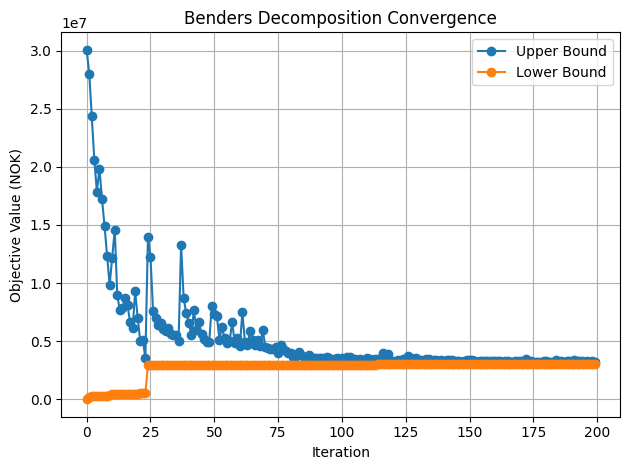

In [12]:

def add_cut(Cuts, Sub, x_fixed):
    cidx = len(Cuts["Set"])
    Cuts["Set"].append(cidx)
    Phi = sum(pyo.value(Sub[s].obj) for s in S)
    Cuts["Phi"][cidx] = Phi
    for t in T:
        lam_sum = sum(Sub[s].dual[Sub[s].balance[t]] for s in S)
        Cuts["Lambda"][(t,cidx)] = -lam_sum
        Cuts["x_fixed"][(t,cidx)] = x_fixed[t]
    return Cuts

def save_results(x_fixed, Sub, UB_hist, LB_hist):
    x_df = pd.DataFrame({"hour": T, "x_t": [int(round(x_fixed[t])) for t in T]})
    x_df.to_csv("x_day_ahead.csv", index=False)
    print("Saved: x_day_ahead.csv")

    rows = []
    for s in S:
        m = Sub[s]
        for t in T:
            rows.append({
                "scenario": s, "hour": t,
                "mkt": pyo.value(m.mkt[t]), "q": pyo.value(m.q[t]), "r": pyo.value(m.r[t]),
                "u": pyo.value(m.u[t]), "l": pyo.value(m.l[t]), "S": pyo.value(m.S[t]),
            })
    pd.DataFrame(rows).to_csv("subproblem_results.csv", index=False)
    print("Saved: subproblem_results.csv")

    it = list(range(len(UB_hist)))
    plt.figure()
    plt.plot(it, UB_hist, marker='o', label='Upper Bound')
    plt.plot(it, LB_hist, marker='o', label='Lower Bound')
    plt.xlabel('Iteration'); plt.ylabel('Objective Value (NOK)')
    plt.title('Benders Decomposition Convergence'); plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig("convergence.png"); print("Saved: convergence.png")

def benders_main():
    solver = pyo.SolverFactory("glpk")
    Cuts = {"Set": [], "Phi": {}, "Lambda": {}, "x_fixed": {}}
    tol, max_iters = 1e-4, 200
    UB_hist, LB_hist = [], []
    prev_x = {t: 0.0 for t in T}

    for k in range(max_iters):
        if len(Cuts["Set"]) == 0:
            x_fixed = {t: 0.0 for t in T}
            alpha_val = 0.0
            LB = 0.0
            print(f"Iter {k:02d} | cuts: 0 | master: BOOTSTRAP x=0, alpha=0")
        else:
            master = build_master(Cuts, integer_x=True)
            resM = solver.solve(master, load_solutions=True)
            print(f"Iter {k:02d} | cuts: {len(Cuts['Set'])} | master(MIP) status: {resM.solver.termination_condition}")
            x_try = {t: master.x[t].value for t in T}
            alpha_try = master.alpha.value

            if any(v is None for v in x_try.values()):
                print("  No MIP values → solving LP relaxation...")
                masterLP = build_master(Cuts, integer_x=False)
                resLP = solver.solve(masterLP, load_solutions=True)
                print(f"  master(LP) status: {resLP.solver.termination_condition}")
                x_try = {t: masterLP.x[t].value for t in T}
                alpha_try = masterLP.alpha.value

            if any(v is None for v in x_try.values()):
                print("  Still no values → fallback to previous x.")
                x_try = prev_x.copy()
                alpha_try = 0.0

            x_fixed = {t: float(x_try[t]) for t in T}
            prev_x = x_fixed.copy()
            alpha_val = float(alpha_try) if alpha_try is not None else 0.0
            LB = sum(c[t]*x_fixed[t] for t in T) + alpha_val

        Sub, q_vals = {}, {}
        for s in S:
            sp = build_subproblem(x_fixed, s)
            resS = solver.solve(sp, load_solutions=True)
            if k == 0 and s == 1:
                lam_sample = {t: float(sp.dual[sp.balance[t]]) for t in range(1,5)}
                print("  sample λ_{t,1}:", lam_sample)
            q_vals[s] = pyo.value(sp.obj)
            Sub[s] = sp

        inv_cost = sum(c[t]*x_fixed[t] for t in T)
        UB = inv_cost + sum(q_vals.values())
        UB_hist.append(UB); LB_hist.append(LB)
        print(f"  LB={LB:.3f}  UB={UB:.3f}  gap={UB-LB:.3e}  alpha={alpha_val:.3f}")

        if (UB - LB) <= tol and len(Cuts["Set"]) > 0:
            print("\nConverged.")
            print(f"Objective ≈ {UB:.3f}")
            print("x_t (day-ahead):")
            for t in T: print(f"  t={t:2d}  x={int(round(x_fixed[t]))}")
            save_results(x_fixed, Sub, UB_hist, LB_hist)
            return

        Cuts = add_cut(Cuts, Sub, x_fixed)
        cidx = Cuts["Set"][-1]
        slope_norm = sum(abs(Cuts["Lambda"][(t,cidx)]) for t in T)
        print(f"  added cut #{cidx}: Phi={Cuts['Phi'][cidx]:.3f}, ||Lambda||_1={slope_norm:.3f}")

    print("\nReached max iterations; saving last incumbent.")
    save_results(x_fixed, Sub, UB_hist, LB_hist)

# Run the algorithm
benders_main()


In [8]:
def run_with_demand_scale(scale: float):
    # Scale D by a factor, run, and restore D
    global D
    D_backup = D.copy()
    try:
        for k in D:
            D[k] = scale * D[k]
        print(f"\n=== Running with demand scaled by {scale:.2f} ===")
        benders_main()
    finally:
        D = D_backup



=== Running with demand scaled by 1.10 ===
Iter 00 | cuts: 0 | master: BOOTSTRAP x=0, alpha=0
  sample λ_{t,1}: {1: 30000.0, 2: 30000.0, 3: 30000.0, 4: 251.1}
  LB=0.000  UB=83373243.723  gap=8.337e+07  alpha=0.000
  added cut #0: Phi=83373243.723, ||Lambda||_1=1637582.680
Iter 01 | cuts: 1 | master(MIP) status: optimal
  LB=616962.004  UB=81146364.627  gap=8.053e+07  alpha=0.000
  added cut #1: Phi=80529402.623, ||Lambda||_1=1508123.500
Iter 02 | cuts: 2 | master(MIP) status: optimal
  LB=633016.510  UB=76581997.989  gap=7.595e+07  alpha=0.000
  added cut #2: Phi=75948981.479, ||Lambda||_1=1409015.440
Iter 03 | cuts: 3 | master(MIP) status: optimal
  LB=678440.542  UB=72289494.153  gap=7.161e+07  alpha=0.000
  added cut #3: Phi=71611053.612, ||Lambda||_1=1399202.080
Iter 04 | cuts: 4 | master(MIP) status: optimal
  LB=706993.593  UB=62798177.941  gap=6.209e+07  alpha=0.000
  added cut #4: Phi=62091184.347, ||Lambda||_1=1369512.280
Iter 05 | cuts: 5 | master(MIP) status: optimal
  LB=

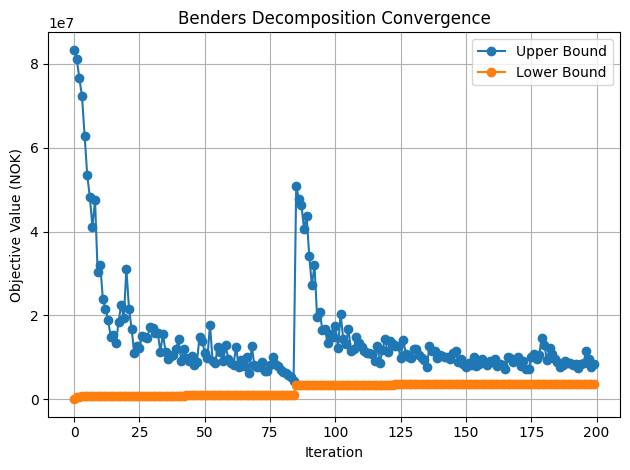

In [9]:
# Example: +10% demand
run_with_demand_scale(1.10)
